In [1]:
import warnings
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import nltk

from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import cv2
from sklearn.manifold import TSNE
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

Num GPUs Available:  0


In [2]:
!python --version

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))



Python 3.11.5
pandas - 2.0.3
numpy - 1.24.3
seaborn - 0.12.2
nltk - 3.8.1
tensorflow - 2.12.0
cv2 - 4.8.1
gensim - 4.3.0


In [3]:
warnings.filterwarnings('ignore')

In [4]:
df =  pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
df.shape

(1050, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
304,95cb9561009bd6707c67f05e6a00c16e,2015-12-01 06:13:00 +0000,http://www.flipkart.com/homedesires-showpiece-...,Homedesires Showpiece - 10.5 cm,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIECV5BYUZEQJT7,899.0,340.0,95cb9561009bd6707c67f05e6a00c16e.jpg,False,Buy Homedesires Showpiece - 10.5 cm for Rs.3...,No rating available,No rating available,Homedesires,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
289,2aaa6083689193df5ab01fe37dea1b5e,2016-04-24 18:34:50 +0000,http://www.flipkart.com/services-junction-gold...,Services Junction Gold Plated Ganesh Idol Show...,"[""Home Decor & Festive Needs >> Showpiece >> C...",SHIEHZRCHVFEEVMR,1799.0,1689.0,2aaa6083689193df5ab01fe37dea1b5e.jpg,False,Key Features of Services Junction Gold Plated ...,No rating available,No rating available,Services Junction,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
399,8720a25546a572b0217817a82bfd00a5,2015-12-01 06:13:00 +0000,http://www.flipkart.com/d-link-dsl-2520u/p/itm...,D-Link DSL-2520U,"[""Computers >> Network Components >> Routers >...",RTRE2XBZFFEZRCFZ,1449.0,800.0,8720a25546a572b0217817a82bfd00a5.jpg,False,Buy D-Link DSL-2520U only for Rs. 1449 from Fl...,4.1,4.1,D-Link,"{""product_specification""=>[{""key""=>""Wireless S..."
429,9fb8662af03c957ade34d4c816d4e903,2016-03-11 06:55:07 +0000,http://www.flipkart.com/smartpro-19-5v-3-9a-re...,"Smartpro 19.5v,3.9a Replacement Charger for Va...","[""Computers >> Laptop Accessories >> Adapters ...",ACCEGZ6BWVQYWWDB,1499.0,539.0,9fb8662af03c957ade34d4c816d4e903.jpg,False,"Key Features of Smartpro 19.5v,3.9a Replacemen...",No rating available,No rating available,Smartpro,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
356,9a02f44389bda4c60e7dc23947dbca58,2015-12-01 06:13:00 +0000,http://www.flipkart.com/playboy-london-berlin-...,Playboy London And Berlin Combo Set,"[""Beauty and Personal Care >> Fragrances >> De...",CAGE4BQXSJPTBUS4,398.0,388.0,9a02f44389bda4c60e7dc23947dbca58.jpg,False,Flipkart.com: Buy Playboy London And Berlin Co...,5,5,NaN,"{""product_specification""=>[{""key""=>""Gift Set C..."


In [8]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [9]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

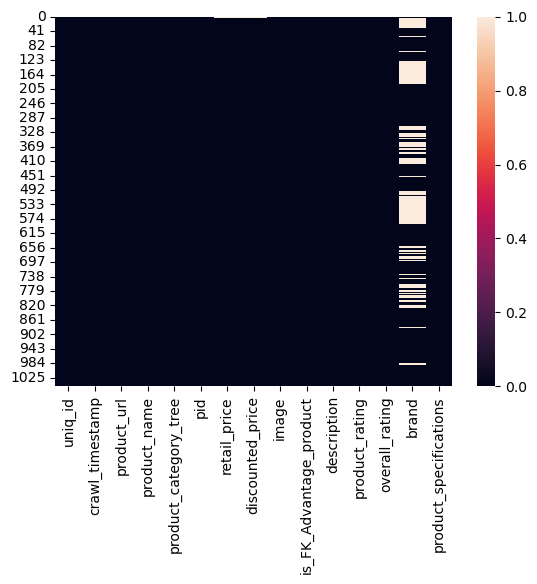

In [10]:
sns.heatmap(df.isnull());

In [11]:
df.duplicated().sum()

0

In [12]:
df.duplicated(subset='description').sum()

0

### Inspection des données 

In [13]:
df.describe(include=np.number)

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


In [14]:
df.describe(include=object)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,1050,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,1,1,889,889,11,22


### Nettoyage des données

In [15]:
df_net = df.dtypes
df_net

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [16]:
cols = ['uniq_id','description']
df_t = df[cols]
df_t.sample(10)

,uniq_id,description
914,762b6b22cccf91935e92446efe298fe3,Specifications of 612 League Baby Boy's Checke...
26,4aa047f14885c74f155ce5f973e14dff,"Disney 98189 Analog Watch - For Boys, Girls -..."
226,f39a2cce8929f5b44087d688995994e4,Buy Tiedribbons We Love Mom With Green Backgro...
298,2971287a1ac427bd98c4778112d20d06,Specifications of JayEnterprise Plastic Hand J...
669,d0fee79693c7dc3132d30491323b6407,Buy Shrikant Traders Cotton Bath Towel at Rs. ...
243,607dc41467008ee7a8dba0276f180f63,Buy Suruchi Kadhai 4.5 L for Rs.965 online. Su...
151,73503fe89ea77420a598f4a1019e5b6d,Prithish Pscychological Illusions Design 5 Cer...
1031,7d2883d833e215d3092c7f53572f870d,Specifications of Kerastase Nutritive Bain Sat...
134,258444ac7bb7ad8026800efad5c3502b,Buy Rajesh Digital BEST DAD 107 Ceramic Mug fo...
410,e39177ad1acf95e44ddd430bf969a86b,Buy Asus RP-N53 Dual-Band Wireless-N600 Range ...


### Valeurs manquantes

In [17]:
df_t.isna().mean()

uniq_id        0.0
description    0.0
dtype: float64

In [18]:
df_t.duplicated(subset="description").sum()

0

## Exploration des données
#### longueur

In [19]:
df_t.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

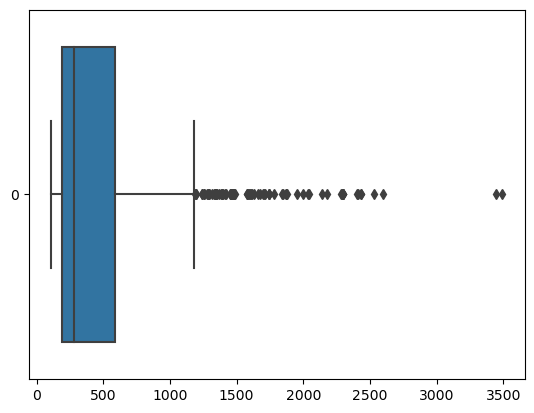

In [20]:
tmp = df_t.description.str.len()
sns.boxplot(tmp, orient='h');

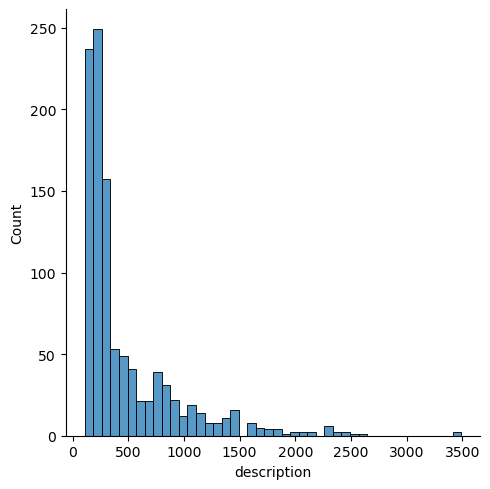

In [21]:
sns.displot(tmp);

In [22]:
df_long = df_t["_lon_desc"] = tmp
df_long.head(10)

0    1420
1     444
2    1258
3     858
4    1197
5     275
6     268
7     817
8     410
9     430
Name: description, dtype: int64

### Exploration du corpus et des documents

In [23]:
df_t.head(10)

,uniq_id,description,_lon_desc
0,55b85ea15a1536d46b7190ad6fff8ce7,Key Features of Elegance Polyester Multicolor ...,1420
1,7b72c92c2f6c40268628ec5f14c6d590,Specifications of Sathiyas Cotton Bath Towel (...,444
2,64d5d4a258243731dc7bbb1eef49ad74,Key Features of Eurospa Cotton Terry Face Towe...,1258
3,d4684dcdc759dd9cdf41504698d737d8,Key Features of SANTOSH ROYAL FASHION Cotton P...,858
4,6325b6870c54cd47be6ebfbffa620ec7,Key Features of Jaipur Print Cotton Floral Kin...,1197
5,893aa5ed55f7cff2eccea7758d7a86bd,Maserati Time R8851116001 Analog Watch - For ...,275
6,f355cc1ccb08bd0d283ed979b7ee7515,"Camerii WM64 Elegance Analog Watch - For Men,...",268
7,dd0e3470a7e6ed76fd69c2da27721041,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,817
8,41384da51732c0b4df3de8f395714fbb,"Alfajr WY16B Youth Digital Watch - For Men, B...",410
9,710ed5f2393a4b9e8823aa0029f71f93,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,430


In [24]:
df_samp = df_t.sample(10)
df_samp

,uniq_id,description,_lon_desc
209,a9b35b94610a3d7f4fa91f19693c5248,Buy Port Interiordesign Showpiece - 16 cm fo...,210
751,a5e1b49a1ddf038888e6de3523b475fb,Buy Rajasthan Crafts Abstract Single Quilts & ...,145
449,49f7763dc9c7ece284a1ae27166f8c6c,Key Features of Saba Garments Baby Girl's Gath...,595
600,20a06aad5f04727dd54bf13dd5923518,Key Features of R&Mshoppee MDF Wall Shelf Tren...,590
540,19a570b6717955a8c48e5f280617ef24,Times 109B0109 Sports Analog Watch - For Boys...,262
76,1971dcd2f3058a4c87bdd7d87d4baeba,Specifications of KE GIFT BOX STOR JEWELLARY V...,239
1025,30ad2acaccdd2e1691a61c44079c2b5a,Key Features of PRINT SHAPES monster universit...,898
952,5be86e35f21b1514d0e7742893d6cfba,Unnati Abstract Single Top Sheet Multicolor\r\...,281
337,7680c6bf930669dc0646e3315187dc8c,Flipkart.com: Buy Arabian Nights Evolve Combo ...,178
777,46c7cb82a768ad8811db821d8649f6e0,RRTC RRTC1105SM00 Basic Analog Watch - For Wo...,272


In [25]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['uniq_id']}\n"
    print( id_prod + ser["description"]+ "..." +"\n\n")

: a9b35b94610a3d7f4fa91f19693c5248
Buy Port Interiordesign Showpiece  -  16 cm for Rs.1699 online. Port Interiordesign Showpiece  -  16 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


: a5e1b49a1ddf038888e6de3523b475fb
Buy Rajasthan Crafts Abstract Single Quilts & Comforters Pink at Rs. 840 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


: 49f7763dc9c7ece284a1ae27166f8c6c
Key Features of Saba Garments Baby Girl's Gathered Dress Rainbow sequece pink party wear gaither gown,Saba Garments Baby Girl's Gathered Dress Price: Rs. 2,750 Tissue net, Cancan net, Cottion lining, stone work.,Specifications of Saba Garments Baby Girl's Gathered Dress Dimensions Length Maxi/Full Length General Details Pattern Solid Ideal For Baby Girl's Occasion Party Dress Details Sleeve Sleeveless Belt Included Yes Number of Contents in Sales Package Pack of 1 Fabric Satin Type Gathered Fabric Care Wash With Similar Co

### Nettoyage de la fonctionalité "description"

In [26]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df_t["cleaned_description"]=df_t["description"].apply(cleaned_text)

In [28]:
df_t["cleaned_description"] = df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [29]:
 df_t["cleaned_description"].head(10)

0    features elegance polyester multicolor abstrac...
1    specifications sathiyas cotton bath towel bath...
2    features eurospa cotton terry face towel size ...
3    features santosh royal fashion cotton printed ...
4    features jaipur print cotton floral king sized...
5    maserati time analog watch boys maserati time ...
6    camerii elegance analog watch boys camerii ele...
7    star analog watch boys price whether your work...
8    alfajr youth digital watch boys alfajr youth d...
9    heuer formula analog watch boys heuer formula ...
Name: cleaned_description, dtype: object

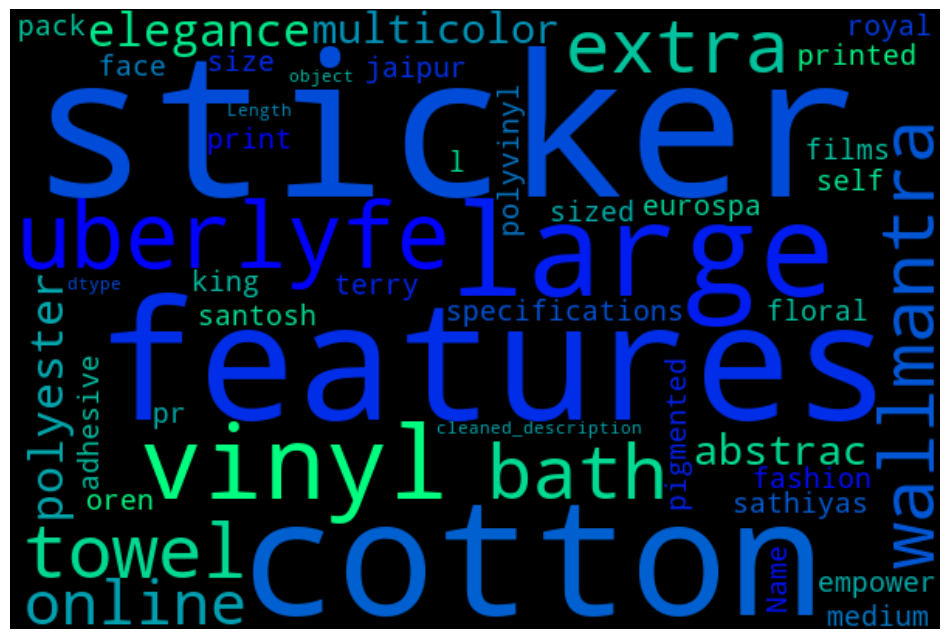

In [30]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(str(df_t["cleaned_description"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [31]:
stop=stopwords.words('english')
stop.append("also")
df_t["stop_removed_description"]=df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [32]:
df_t["tokenized"]=df_t["stop_removed_description"].apply(lambda x: nltk.word_tokenize(x))

In [33]:
from nltk.stem import WordNetLemmatizer 

In [34]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df_t["lemmatized"]=df_t["tokenized"].apply(lambda x: word_lemmatizer(x))
df_t["lemmatize_joined"]=df_t["lemmatized"].apply(lambda x: ' '.join(x))

In [35]:
df_t["lemmatize_joined"].head()

0    feature elegance polyester multicolor abstract...
1    specifications sathiyas cotton bath towel bath...
2    feature eurospa cotton terry face towel size s...
3    feature santosh royal fashion cotton print kin...
4    feature jaipur print cotton floral king size d...
Name: lemmatize_joined, dtype: object

In [36]:
df_t['Nombre de mots après nettoyage'] = df_t['lemmatize_joined'].apply(lambda x:len(str(x).split()))

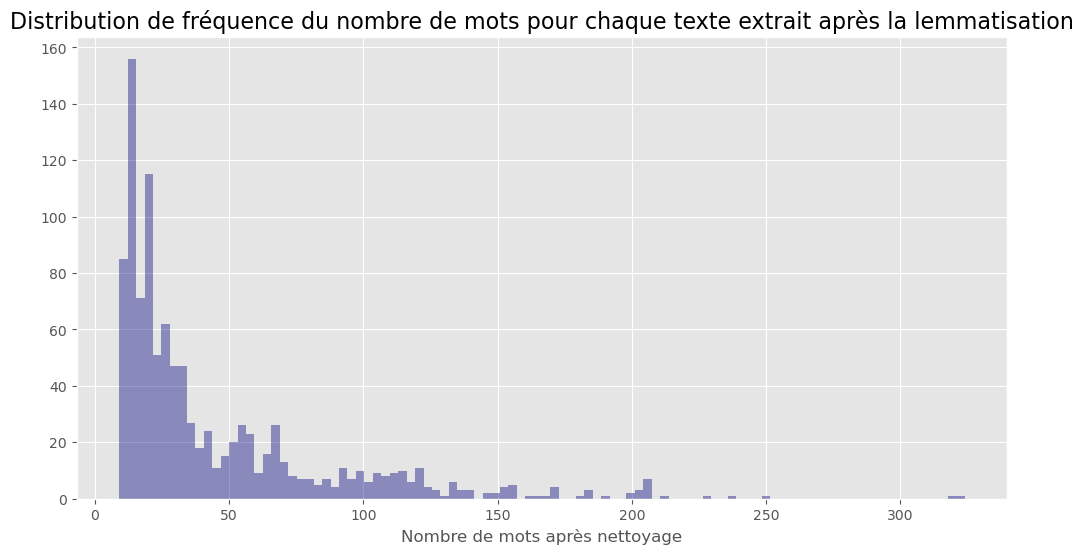

In [37]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "navy", bins = 100)
plt.title("Distribution de fréquence du nombre de mots pour chaque texte extrait après la lemmatisation", size=16);

In [38]:
df_t.drop(df_t[df_t["Nombre de mots après nettoyage"]>300].index, inplace = True)

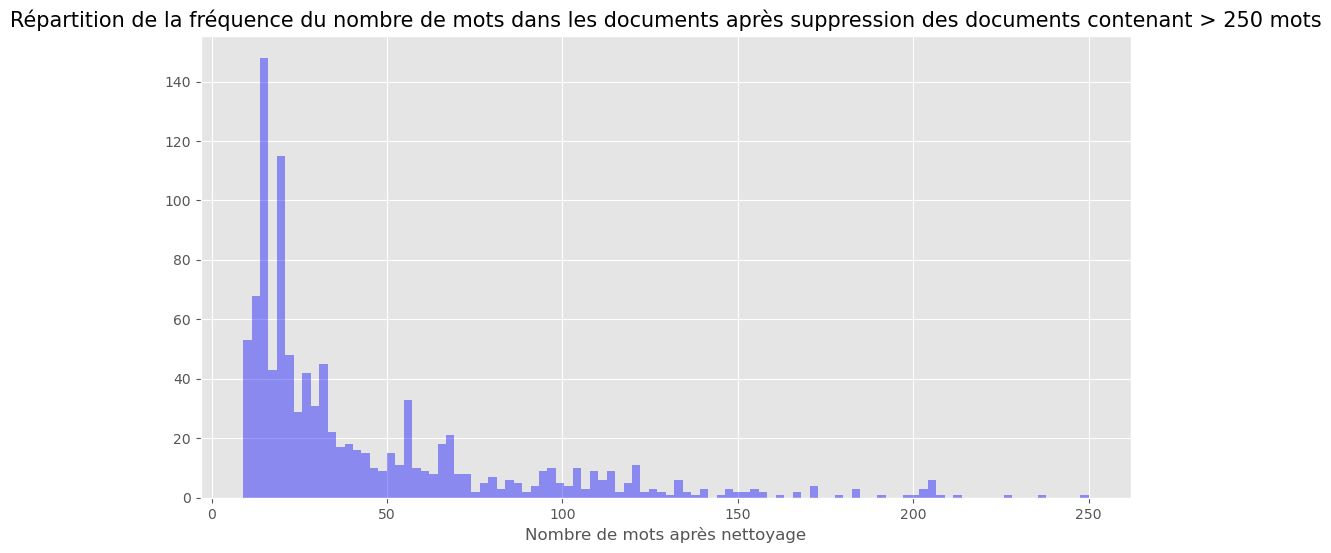

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "blue", bins = 100)
plt.title("Répartition de la fréquence du nombre de mots dans les documents après suppression des documents contenant > 250 mots", size=15);

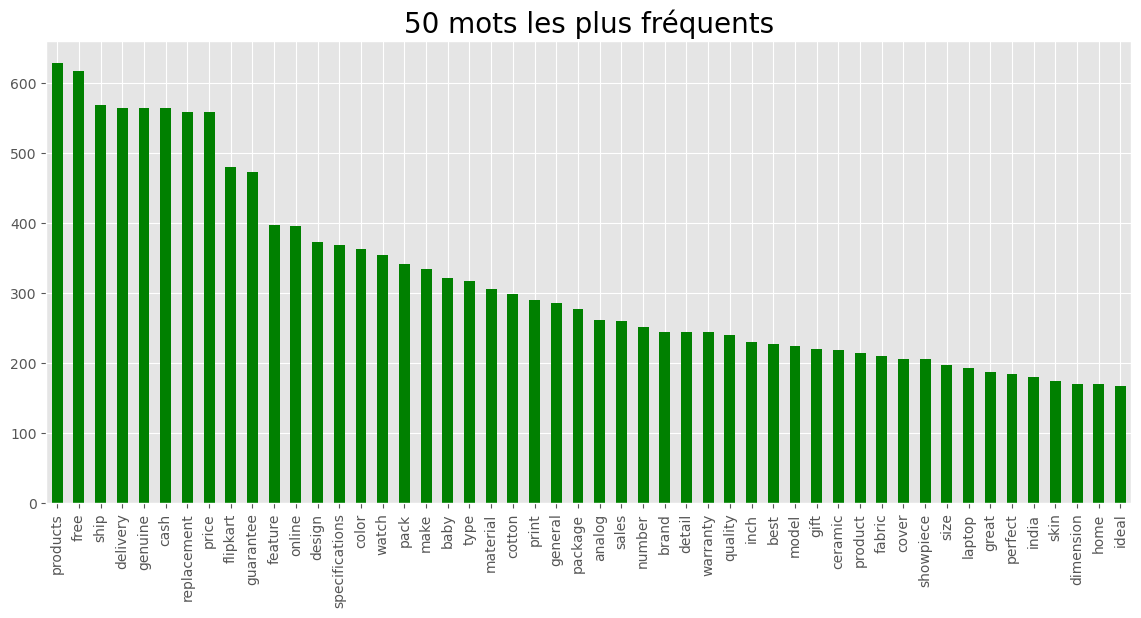

In [40]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df_t["lemmatize_joined"]).split()).value_counts()[:50]
freq.plot(kind="bar", color = "green")
plt.title("50 mots les plus fréquents",size=20);

In [41]:

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors


In [42]:
tokens = df_t["lemmatize_joined"].apply(lambda x: nltk.word_tokenize(x))

In [43]:
w2v_model = Word2Vec(tokens,
                     min_count=300,
                     window=10,                   
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

In [44]:
v1 = w2v_model.wv['products']
print(v1)

[-0.0208236   0.01317196  0.15419655  0.04948722 -0.02521323  0.0810229
 -0.10824843  0.0235831  -0.06556628 -0.02790437 -0.03957542  0.13365595
  0.06371072  0.21698323  0.09642079  0.08960048  0.00894242 -0.26398373
 -0.10102919  0.02733186 -0.28514287 -0.05064995  0.10102674  0.07405858
  0.21477216 -0.10090094  0.05748675  0.03750748 -0.09354229 -0.00073426
 -0.01886713 -0.03516732 -0.11556069  0.17220792  0.10031628 -0.01112411
  0.10254081 -0.44487464 -0.08355723  0.096874    0.1624871  -0.00994655
  0.14998879 -0.12221223 -0.05295964 -0.03985317  0.10455021  0.18698141
  0.34822404 -0.10411472  0.02833165 -0.17420667 -0.18876196  0.14240028
  0.10409144 -0.079183   -0.00707474  0.15460959  0.01972981  0.086686
  0.22330423  0.05071633 -0.29660195  0.22154625  0.20751236 -0.00602391
  0.02678572  0.00873841  0.06689092 -0.20243019  0.08984143 -0.14077395
 -0.0849827  -0.11436535  0.13244636 -0.08966927  0.10531888 -0.18032405
 -0.17322926 -0.02449313  0.15565634  0.02328746 -0.16

In [45]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
tsne_plot(w2v_model)